## Лабараторная №3

Выканаў __Трафімаў Аляксандр__

-------

3.Построение выпуклой оболочки бинарного изображения

Разработать программу построения выпуклой оболочки на основе преобразований утолщения для бинарных изображений. 

Алгоритмы - в 5-й главе первой части спецкурса (с. 22-24)

In [1]:
import skimage
from skimage import morphology as skmorph
from scipy.ndimage import morphology as ndmorph
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.titlesize'] = 17

In [3]:
def show_images(images, titles=None, cols=4, width=7, height=5, to_show_axis=False):
    rows = len(images) // cols + (1 if len(images) % cols > 0 else 0)
    fig, ax = plt.subplots(
        rows, cols, figsize=(width * cols, height * rows), squeeze=False)
    ax_flatten = ax.flatten()
    
    if titles is not None:
        if not len(images) == len(titles):
            raise ValueError('images and title must have the same len')
    
    for i in range(len(images)):
        ax_flatten[i].imshow(images[i]);
        if not to_show_axis: ax_flatten[i].axis('off')
        if titles is not None: ax_flatten[i].set_title(titles[i])
    for i in range(len(images), len(ax_flatten)):
        ax_flatten[i].set_visible(False)
    fig.tight_layout()
    fig.subplots_adjust(top=(0.85 if titles is not None else 0.95))
    return fig, ax

## create structural elements for 45-convex hull

In [4]:
t = [np.array([
    [ 1,  1,  1],
    [ 0, -1,  1],
    [ 0,  0,  0]
])]
for i in range(3):
    t.append(np.rot90(t[-1]))
t.append(np.array([
    [ 1,  1,  1],
    [ 1, -1,  0],
    [ 0,  0,  0]
]))
for i in range(3):
    t.append(np.rot90(t[-1]))
    
selements = [{
    'a': np.where(x == 1, 1, 0),
    'b': np.where(x == -1, 1, 0)
} for x in t]

# view structural elements
if False:
    print('all the structural elements:')
    for ix, s in enumerate(selements):
        print('=================')
        print(f't: {ix + 1}')
        print('a:')
        print(s['a'])
        print('b:')
        print(s['b'])

In [5]:
def thick_with_a_b(img, a, b, to_log=False):
    lhs = ndmorph.binary_erosion(img, a)
    bg = np.logical_not(img)
    rhs = ndmorph.binary_erosion(bg, b)
    x = np.logical_and(lhs, rhs)
    res = np.logical_or(img, x)
    if to_log:
        print('a')
        print(a)
        print('b')
        print(b)
        print('lhs')
        print(lhs.astype(np.int))
        print('rhs')
        print(rhs.astype(np.int))
        print('x')
        print(x.astype(np.int))
    return res

In [6]:
def thick_iteration(img, selements):
    res = img.copy()
    for s in selements:
        res = thick_with_a_b(res, *s.values())
    return res

In [7]:
def get_convex_hull(img, selements, max_iters=500, delta_iters=20):
    n = 0
    prev_res = img.copy()
    res = thick_iteration(img, selements)
    partial = []
    while not np.array_equal(prev_res, res) and n + 1 < max_iters:
        n += 1
        if n % delta_iters == 0:
            partial.append((n, res))
        prev_res = res.copy()
        res = thick_iteration(res, selements)
    print(f'total number of iterations: {n}')
    return res, partial

## load image

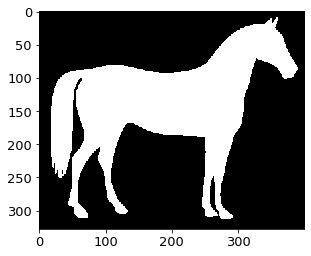

In [8]:
horse = skimage.data.horse()
horse = ~horse # invert image
plt.imshow(horse);

## build 45-convex hull

In [9]:
res, partial = get_convex_hull(horse, selements)

total number of iterations: 435


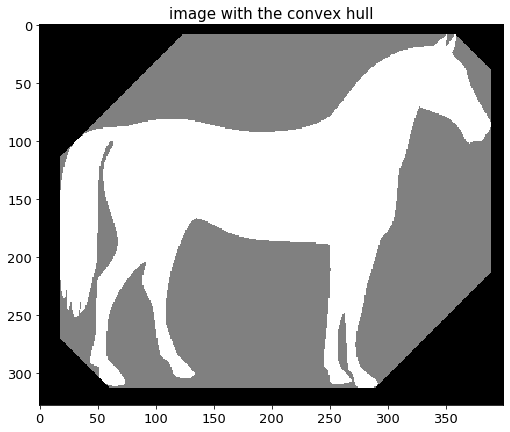

In [10]:
plt.figure(figsize=(10, 7))
plt.imshow(res);
plt.imshow(horse, alpha=.5);
plt.title('image with the convex hull');

## partial results

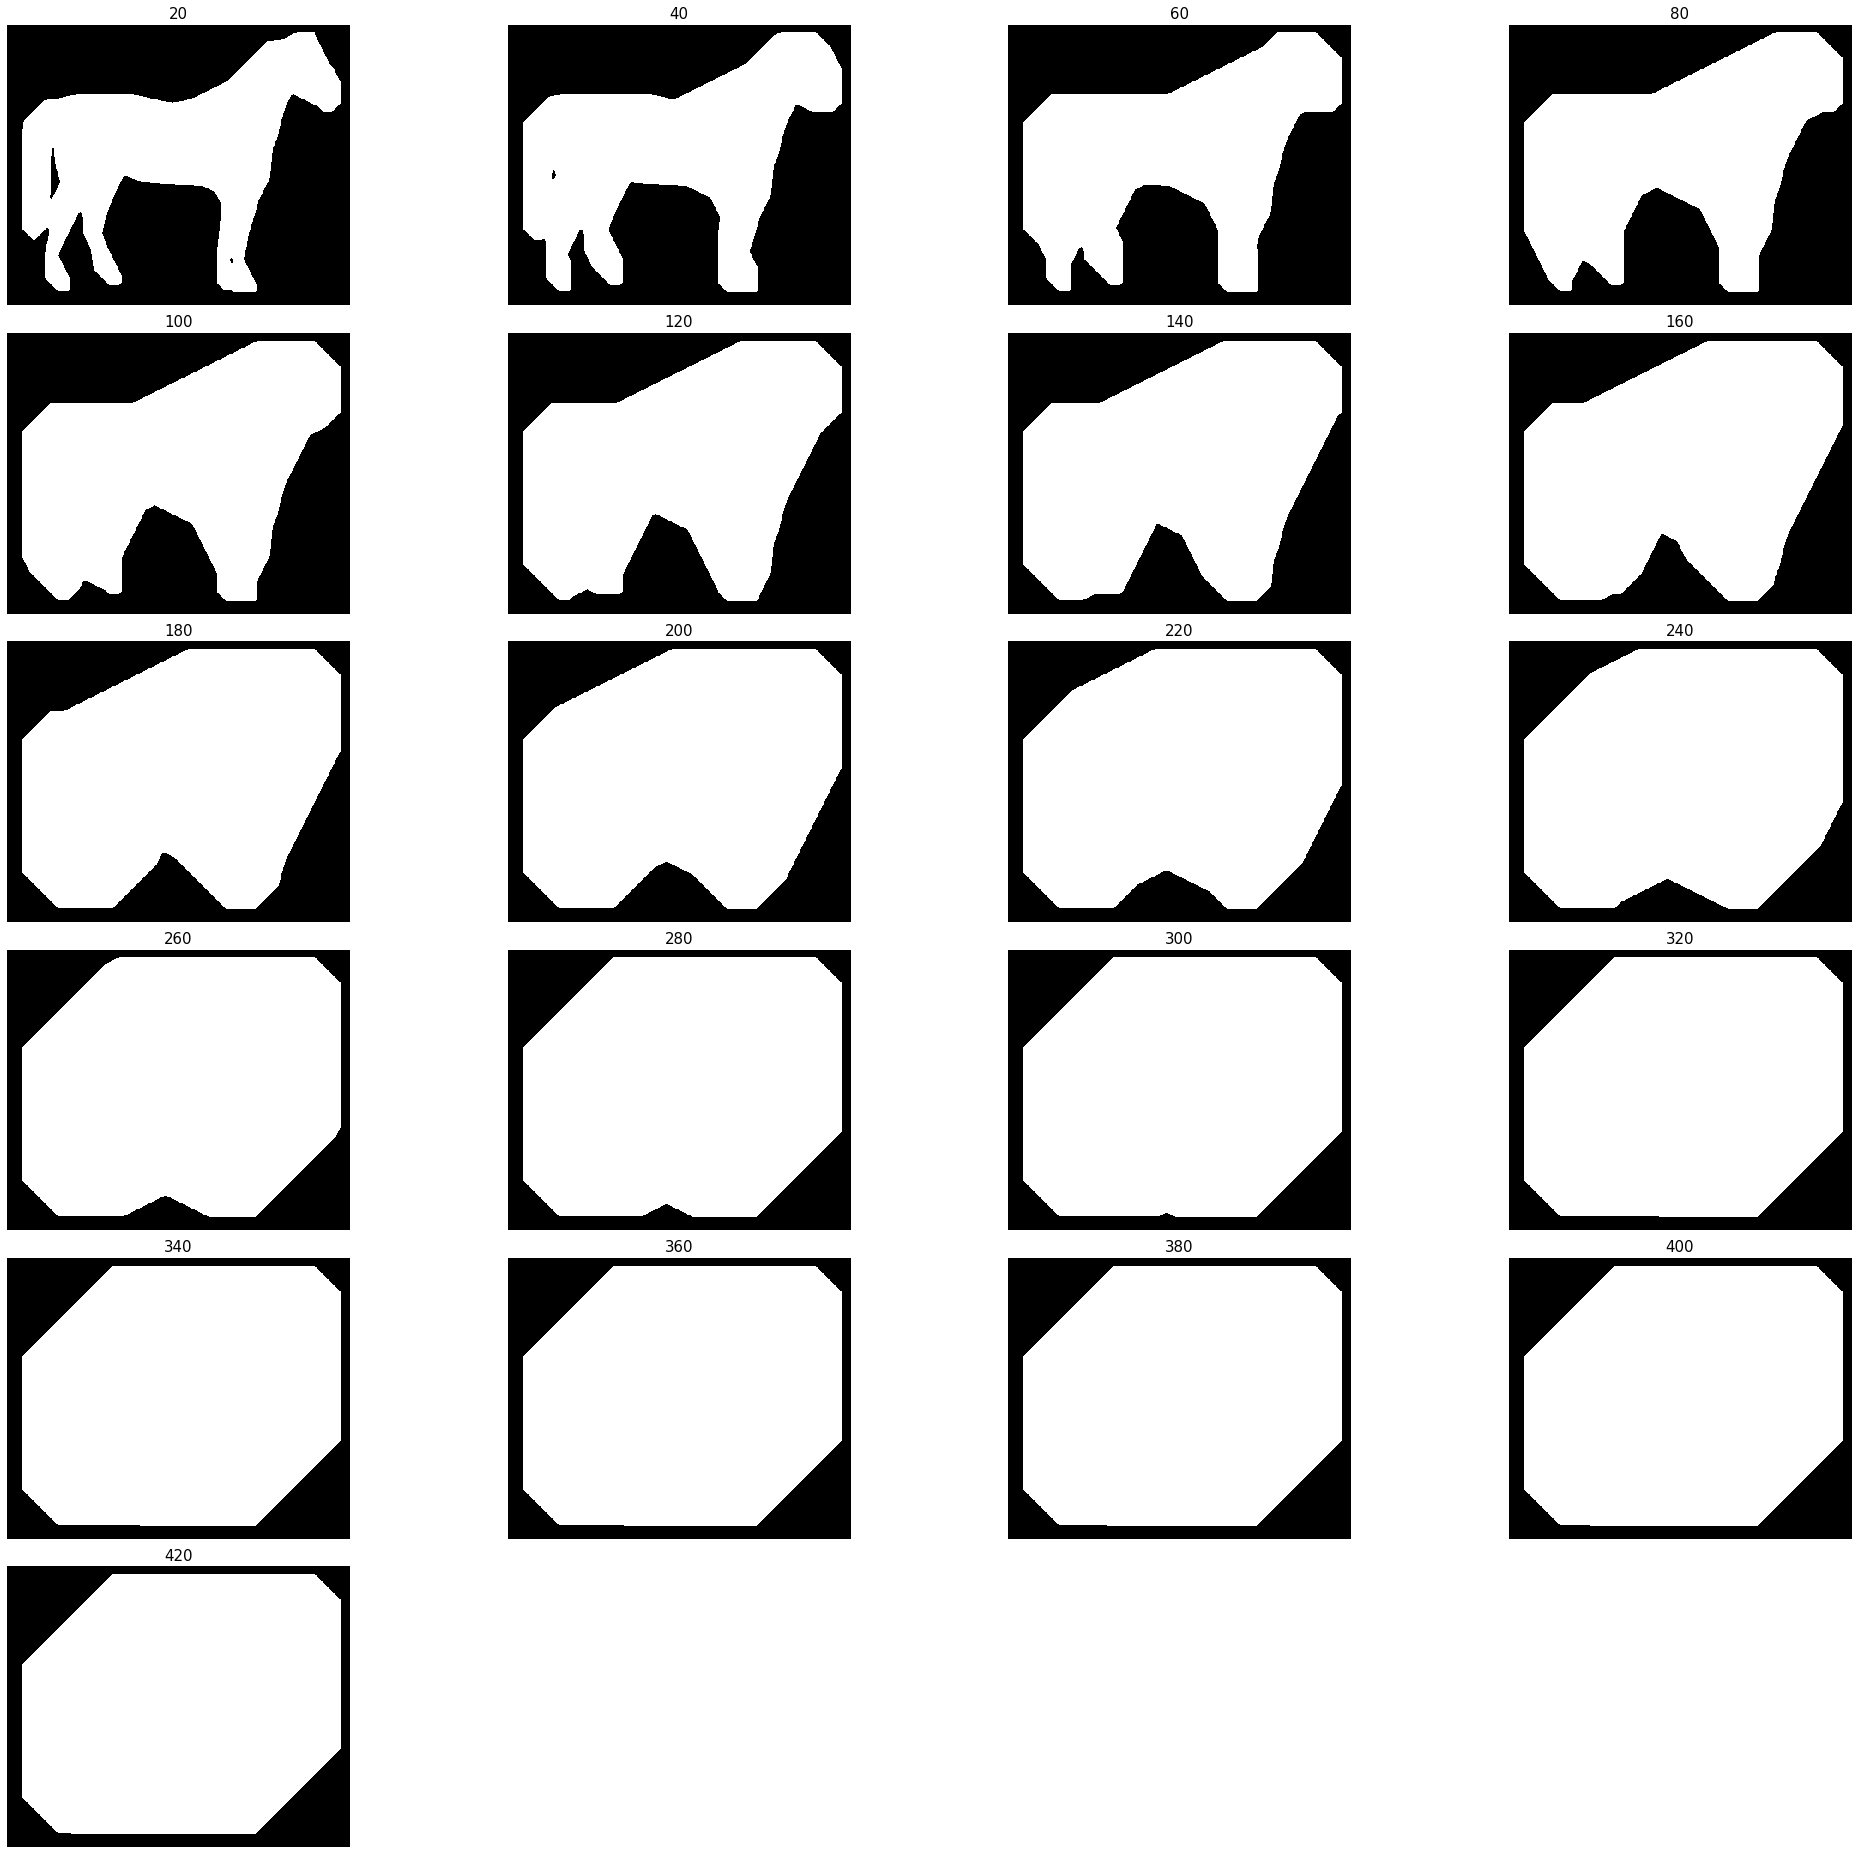

In [11]:
show_images([x[1] for x in partial], titles=[x[0] for x in partial]);

## skimage's convex hull

In [12]:
skhull = skmorph.convex_hull_image(horse)

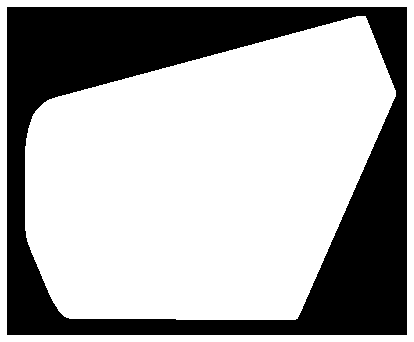

In [13]:
show_images([skhull]);

### our's result differs from the skimage's one because we use structural elements that create convex hull with segments parallel and at 45-degrees angle to the image axes